In [1]:
import numpy as np
import random as rand
import pandas as pd

import diff_classifier.msd as msd
import matplotlib.pyplot as plt
import diff_classifier.heatmaps as hm
import diff_classifier.aws as aws
from scipy.ndimage.morphology import distance_transform_edt as eudist

In [2]:
def checkerboard_mask(dims=(512,512), squares=50, width=25):
    """Creates a 2D Boolean checkerboard mask
    
    Creates a Boolean array of evenly spaced squares.
    Whitespace is set to True.
    
    Parameters
    ----------
    
    dims : tuple of int
        Dimensions of desired Boolean array
    squares : int
        Dimensions of in individual square in array
    width : int
        Dimension of spacing between squares
        
    Returns
    ----------
    
    zeros : numpy.ndarray of bool
        2D Boolean array of evenly spaced squares
    
    """
    zeros = np.zeros(dims) == 0
    square_d = squares

    loy = width
    hiy = loy + square_d

    for j in range(1050):

        lox = width
        hix = lox + square_d
        for i in range(1050):

            if hix < 512 and hiy < 512:
                zeros[loy:hiy, lox:hix] = False
            elif hix < 512:
                zeros[loy:512-1, lox:hix] = False
            elif hiy < 512:
                zeros[loy:hiy, lox:512-1] = False
            else:
                zeros[loy:512-1, lox:512-1] = False
                break

            lox = hix + width
            hix = lox + square_d

        loy = hiy + width
        hiy = loy + square_d
        
    return zeros

In [ ]:
checkerboard_mask().dtype

In [ ]:
checkerboard_mask().shape

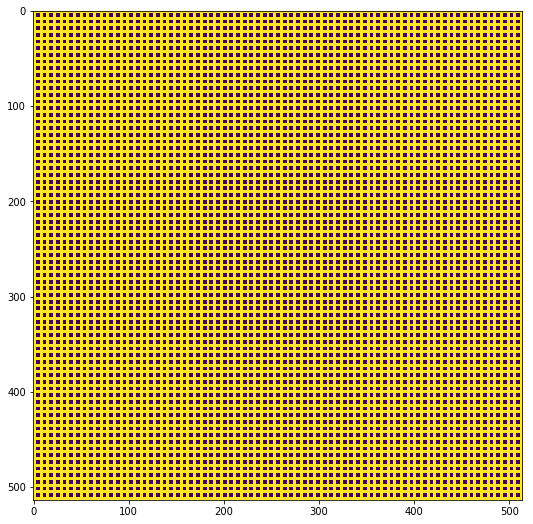

In [4]:
plt.figure(figsize=(9,9))
plt.imshow(checkerboard_mask(dims=(514,514), squares=4, width=3))

In [4]:
def random_walk(nsteps=100, seed=None, start=(0, 0), step=1, mask = None, stuckprob = 0.5):
    if type(mask) is np.ndarray:
        while not mask[start[0], start[1]]:
            start = (start[0], start[1]-1)
    
    np.random.seed(seed=seed)

    x = np.zeros(nsteps)
    y = np.zeros(nsteps)
    x[0] = start[0]
    y[0] = start[1]
    eumask = eudist(~mask)

    if not type(mask) is np.ndarray: #Checks to see if a mask is being used first
        for i in range(1, nsteps):
            val = rand.randint(1, 4)
            if val == 1:
                x[i] = x[i - 1] + step
                y[i] = y[i - 1]
            elif val == 2:
                x[i] = x[i - 1] - step
                y[i] = y[i - 1]
            elif val == 3:
                x[i] = x[i - 1]
                y[i] = y[i - 1] + step
            else:
                x[i] = x[i - 1]
                y[i] = y[i - 1] - step
    else:
        #print("Applied mask")
        for i in range(1, nsteps):
            val = rand.randint(1, 4)
            # Makes sure within mask dimensions
            if x[i-1] > mask.shape[0] - 1:
                x[i-1] = mask.shape[0] - 1
            elif y[i-1] > mask.shape[0] - 1:
                y[i-1] = mask.shape[0] - 1
        
            if mask[int(x[i-1]), int(y[i-1])]: #If mask is being used, checks if entry is in mask or not
                if val == 1:
                    x[i] = x[i - 1] + step
                    y[i] = y[i - 1]
                elif val == 2:
                    x[i] = x[i - 1] - step
                    y[i] = y[i - 1]
                elif val == 3:
                    x[i] = x[i - 1]
                    y[i] = y[i - 1] + step
                else:
                    x[i] = x[i - 1]
                    y[i] = y[i - 1] - step
            elif np.random.rand() > stuckprob: #If it does cross into a False area, probability to be stuck
                x[i] = x[i - 1]
                y[i] = y[i - 1]
                
                
                while eumask[int(x[i]), int(y[i])] > 0:
                    vals = np.zeros(4)
                    vals[0] = eumask[int(x[i] + step), int(y[i])]
                    vals[1] = eumask[int(x[i] - step), int(y[i])]
                    vals[2] = eumask[int(x[i]), int(y[i] + step)]
                    vals[3] = eumask[int(x[i]), int(y[i] - step)]
                    vali = np.argmin(vals)
                    
                    if vali == 0:
                        x[i] = x[i] + step
                        y[i] = y[i]
                    elif vali == 1:
                        x[i] = x[i] - step
                        y[i] = y[i]
                    elif vali == 2:
                        x[i] = x[i]
                        y[i] = y[i] + step
                    else:
                        x[i] = x[i]
                        y[i] = y[i] - step

            else: #Otherwise, particle is stuck on "cell"
                x[i] = x[i - 1]
                y[i] = y[i - 1]
                

    return x, y

In [5]:
def random_traj_dataset(nframes=100, nparts=30, seed=1, fsize=(0, 512),
                        step=1, mask=None, stuckprob=0.5, ndist=None):
    """Creates a random population of random walks.

    Parameters
    ----------
    nframes : int
        Number of frames for each random trajectory.
    nparts : int
        Number of particles in trajectory dataset.
    seed : int
        Seed for pseudo-random number generator for reproducability.
    fsize : tuple of int or float
        Scope of points over which particles may start at.
    ndist : tuple of int or float
        Parameters to generate normal distribution, mu and sigma.

    Returns
    -------
    dataf : pandas.core.frame.DataFrame
        Trajectory data containing a 'Frame', 'Track_ID', 'X', and
        'Y' column.

    """

    frames = []
    trackid = []
    x = []
    y = []
    start = [0, 0]
    pseed = seed

    for i in range(0, nparts+1):
        rand.seed(a=i+pseed)
        start[0] = rand.randint(fsize[0], fsize[1])
        rand.seed(a=i+3+pseed)
        start[1] = rand.randint(fsize[0], fsize[1])
        rand.seed(a=i+5+pseed)
        if type(ndist) is tuple:
            weight = rand.normalvariate(mu=ndist[0], sigma=ndist[1])
        else:
            weight = 1

        trackid = np.append(trackid, np.array([i]*nframes))
        xi, yi = random_walk(nsteps=nframes, seed=i,
                             start=(start[0], start[1]),
                             step=step+weight , mask=mask,
                             stuckprob=stuckprob)
        x = np.append(x, xi)
        y = np.append(y, yi)
        frames = np.append(frames, np.linspace(0, nframes-1, nframes))

    datai = {'Frame': frames,
             'Track_ID': trackid,
             'X': x,
             'Y': y,
             'Quality': (nframes)*(nparts+1)*[10],
             'SN_Ratio': (nframes)*(nparts+1)*[0.1],
             'Mean_Intensity': (nframes)*(nparts+1)*[120]}
    
    print(len(frames))
    print(len(trackid))
    print(x.shape)
    print(y.shape)
    print(len((nframes)*(nparts+1)*[10]))
    print(len((nframes)*(nparts+1)*[10]))
    print(len((nframes)*(nparts+1)*[10]))
    dataf = pd.DataFrame(data=datai)

    return dataf

In [50]:
random_walk(mask = checkerboard_mask(dims=(514,514), width=9), stuckprob = 0.5)

(array([  0.,  -1.,  -2.,  -3.,  -4.,  -5.,  -5.,  -4.,  -3.,  -3.,  -2.,
         -2.,  -3.,  -3.,  -4.,  -5.,  -6.,  -7.,  -7.,  -6.,  -5.,  -5.,
         -6.,  -5.,  -6.,  -6.,  -6.,  -5.,  -6.,  -6.,  -6.,  -5.,  -5.,
         -6.,  -6.,  -5.,  -6.,  -6.,  -6.,  -6.,  -5.,  -4.,  -5.,  -5.,
         -6.,  -7.,  -8.,  -8.,  -8.,  -9.,  -9.,  -9., -10.,  -9., -10.,
        -11., -12., -12., -12., -12., -11., -11., -11., -11., -11., -12.,
        -11., -11., -11., -11., -11., -11., -12., -12., -12., -12., -12.,
        -12., -13., -13., -12., -11., -12., -12., -11., -10., -11., -11.,
        -11., -11., -10.,  -9.,  -8.,  -9.,  -9.,  -9.,  -9.,  -9., -10.,
         -9.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,
         2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  1.,
         2.,  2.,  2.,  3.,  4.,  4.,  3.,  3.,  2.,  2.,  2.,  1.,  2.,
         1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0., -1., -2.,
        -2., -2., -2., -2.

In [6]:
bucket = 'ccurtis.data'
folder = 'test'
names = []

geomean = {}
gSEM = {}

counter = 1
for i in [60, 28, 17, 12, 8, 6, 4, 3, 2, 1]:
    print('On experiment {}'.format(i))
    #dataf = random_traj_dataset(nframes=200, nparts=500, mask=checkerboard_mask(dims=(514,514), squares=4, width=i), stuckprob=0.99)
    sample_name = 'stuck_spacing99_{}'.format(counter)
    #dataf.to_csv('Traj_{}.csv'.format(sample_name))
    #msds = msd.all_msds(dataf)
    #filename = 'msd_{}.csv'.format(sample_name)
    #msds.to_csv(filename)
    
    names.append(sample_name)
#     aws.upload_s3(filename, '{}/{}'.format(folder, filename), bucket_name=bucket)
#     geomean[sample_name], gSEM[sample_name] = msd.geomean_msdisp(sample_name, umppx=1, fps=1,
#                                                                  remote_folder=folder, bucket=bucket)
    
    counter += 1

On experiment 60
On experiment 28
On experiment 17
On experiment 12
On experiment 8
On experiment 6
On experiment 4
On experiment 3
On experiment 2
On experiment 1


In [46]:
# Quick fix
geomean = {}
gSEM = {}
backup_frames = 200

counter = 1
for i in [60, 28, 17, 12, 8, 6, 4, 3, 2, 1]:
    sample_name = 'stuck_spacing99_{}'.format(counter)
    filename = 'msd_{}.csv'.format(sample_name)
    msds = pd.read_csv(filename, index_col='Unnamed: 0')
    print(msds.head())
#     msds['Track_ID'] = msds['Track_ID'] - 1
#     msds.to_csv(filename)
#     print(msds.head())
#     aws.upload_s3(filename, '{}/{}'.format(folder, filename), bucket_name=bucket)
#     geomean[sample_name], gSEM[sample_name] = msd.geomean_msdisp(sample_name, umppx=1, fps=1,
#                                                                  remote_folder=folder, bucket=bucket)
    
    counter += 1

10
   Frame  Track_ID      X      Y      MSDs      Gauss
0    1.0       1.0  139.0  240.0  0.000000   0.000000
1    2.0       1.0  139.0  238.0  0.121212  16.500000
2    3.0       1.0  139.0  238.0  0.142132  14.071429
3    4.0       1.0  139.0  238.0  0.204082   9.800000
4    5.0       1.0  139.0  238.0  0.266667   7.500000
   Frame  Track_ID      X      Y      MSDs      Gauss
0    1.0       0.0  139.0  240.0  0.000000   0.000000
1    2.0       0.0  139.0  238.0  0.121212  16.500000
2    3.0       0.0  139.0  238.0  0.142132  14.071429
3    4.0       0.0  139.0  238.0  0.204082   9.800000
4    5.0       0.0  139.0  238.0  0.266667   7.500000


In [31]:
# Second quick fix
import numpy.ma as ma
import scipy.stats as stats
counter = 1
geomean = {}
for i in [60, 28, 17, 12, 8, 6, 4, 3, 2, 1]:
    sample_name = 'stuck_spacing99_{}'.format(counter)
    prefix = sample_name
    umppx = 1
    fps = 1
    merged = pd.read_csv('msd_{}.csv'.format(prefix))
    particles = int(max(merged['Track_ID']))
    frames = int(max(merged['Frame']))
    ypos = np.zeros((particles+1, frames))

    for i in range(0, particles+1):
        ypos[i, :] = merged.loc[merged.Track_ID == i, 'MSDs']*umppx*umppx
        xpos = merged.loc[merged.Track_ID == i, 'Frame']/fps

    geo_mean = np.nanmean(ma.log(ypos), axis=0)
    geo_stder = ma.masked_equal(stats.sem(ma.log(ypos), axis=0,
                                          nan_policy='omit'), 0.0)
    geomean[sample_name] = geo_mean.data
    
    np.savetxt('geomean_{}.csv'.format(prefix), geo_mean, delimiter=",")
    np.savetxt('geoSEM_{}.csv'.format(prefix), geo_stder, delimiter=",")
    print(np.exp(geomean[sample_name][100])/np.exp(geomean['stuck_spacing99_1'][100]))
    #print(geo_mean[0])
    counter += 1

1.0
0.9212956603975517
0.8304619296108895
0.7593733384555746
0.586165667433042
0.4660021574939352
0.3319298886961555
0.2246308800350826
0.14674391984852853
0.12780912028573205


In [47]:
# Second quick fix
import numpy.ma as ma
import scipy.stats as stats
counter = 1
geomean = {}
for i in [60, 28, 17, 12, 8, 6, 4, 3, 2, 1]:
    sample_name = 'stuck_spacing99_{}'.format(counter)
    prefix = sample_name
    umppx = 1
    fps = 1
    merged = pd.read_csv('msd_{}.csv'.format(prefix))
    particles = int(max(merged['Track_ID']))
    frames = int(max(merged['Frame']))
    ypos = np.zeros((particles+1, frames))

    for i in range(0, particles+1):
        ypos[i, :] = merged.loc[merged.Track_ID == i, 'MSDs']*umppx*umppx
        xpos = merged.loc[merged.Track_ID == i, 'Frame']/fps

    geo_mean = np.nanmean(ma.log(ypos), axis=0)
    geo_stder = ma.masked_equal(stats.sem(ma.log(ypos), axis=0,
                                          nan_policy='omit'), 0.0)
    geomean[sample_name] = geo_mean.data
    
    np.savetxt('geomean_{}.csv'.format(prefix), geo_mean, delimiter=",")
    np.savetxt('geoSEM_{}.csv'.format(prefix), geo_stder, delimiter=",")
    print(np.exp(geomean[sample_name][100])/np.exp(geomean['stuck_spacing99_1'][100]))
    #print(geo_mean[0])
    counter += 1

1.0
0.6175393182607483
0.4158557469808235
0.18044808345698077
0.07960177152175064
0.05618437848493364
0.03210217053357471
0.0213549587470698
0.01440960401054141
0.01620570788849564


In [42]:
merged

,Unnamed: 0,Frame,Track_ID,X,Y,MSDs,Gauss
0,0,1.0,1.0,139.0,240.0,0.000000,0.000000
1,1,2.0,1.0,139.0,238.0,0.121212,16.500000
2,2,3.0,1.0,139.0,238.0,0.142132,14.071429
3,3,4.0,1.0,139.0,238.0,0.204082,9.800000
4,4,5.0,1.0,139.0,238.0,0.266667,7.500000
5,5,6.0,1.0,139.0,238.0,0.371134,8.981481
6,6,7.0,1.0,139.0,238.0,0.476684,8.573724
7,7,8.0,1.0,139.0,238.0,0.583333,7.836735
8,8,9.0,1.0,139.0,238.0,0.691099,7.103306
9,9,10.0,1.0,139.0,238.0,0.800000,6.447368


In [30]:
geo_mean = np.nanmean(ma.log(ypos), axis=0)
geo_stder.data

array([0.        , 0.0104569 , 0.01088476, 0.01142017, 0.01187968,
       0.01228997, 0.01262043, 0.01291617, 0.01318787, 0.01344098,
       0.01368211, 0.0138755 , 0.01410058, 0.014313  , 0.0145337 ,
       0.01480428, 0.01507183, 0.01534041, 0.01559795, 0.01586938,
       0.01612394, 0.01638132, 0.01667697, 0.01694959, 0.01723345,
       0.01748314, 0.01777122, 0.01806176, 0.0183571 , 0.01861652,
       0.01886658, 0.01912238, 0.01939212, 0.01964652, 0.0199133 ,
       0.02018017, 0.0204208 , 0.02065281, 0.02088643, 0.02112463,
       0.02138094, 0.02162986, 0.02186138, 0.02210392, 0.02236663,
       0.02263419, 0.02289584, 0.02318559, 0.02348099, 0.02377142,
       0.02405737, 0.02430815, 0.02454757, 0.02475151, 0.02496292,
       0.02514299, 0.02533394, 0.02550621, 0.02569358, 0.02590882,
       0.02612275, 0.02634842, 0.02659682, 0.02684218, 0.02709172,
       0.02734955, 0.02762561, 0.02789134, 0.02812147, 0.02836526,
       0.02860099, 0.02887107, 0.02914539, 0.02937913, 0.02959

In [21]:
msds[msds['Track_ID']==0]

,Frame,Track_ID,X,Y,MSDs,Gauss
0,1.0,0.0,139.0,240.0,0.000000,0.000000
1,2.0,0.0,139.0,238.0,1.171717,1.706897
2,3.0,0.0,139.0,238.0,2.253807,1.846725
3,4.0,0.0,139.0,238.0,3.061224,1.646400
4,5.0,0.0,139.0,238.0,3.671795,1.311523
5,6.0,0.0,139.0,238.0,4.412371,1.164949
6,7.0,0.0,139.0,238.0,5.098446,1.042881
7,8.0,0.0,139.0,238.0,5.645833,0.966000
8,9.0,0.0,139.0,238.0,6.261780,0.896237
9,10.0,0.0,139.0,238.0,6.947368,0.863636


In [16]:
geomean = {}
gSEM = {}
counter = 1
for i in [60, 28, 17, 12, 8, 6, 4, 3, 2, 1]:
    sample_name = 'stuck_spacing_{}'.format(counter)
    geomean[sample_name] = np.genfromtxt('geomean_{}.csv'.format(prefix))
    gSEM[sample_name] = np.genfromtxt('geoSEM_{}.csv'.format(prefix))
    print(np.exp(geomean[sample_name][100])/np.exp(geomean['stuck_spacing_1'][100]))
    counter += 1

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [ ]:
np.read

In [11]:
names

['stuck_spacing_1',
 'stuck_spacing_2',
 'stuck_spacing_3',
 'stuck_spacing_4',
 'stuck_spacing_5',
 'stuck_spacing_6',
 'stuck_spacing_7',
 'stuck_spacing_8',
 'stuck_spacing_9',
 'stuck_spacing_10']

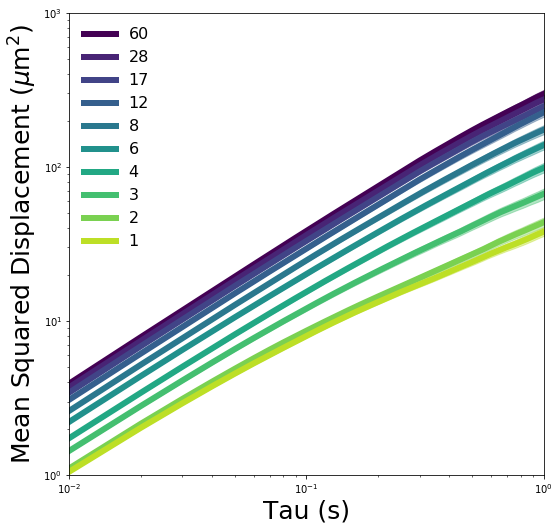

In [12]:
msd.plot_all_experiments(names,
                         yrange=(10**-0, 10**3), bucket=bucket, folder=folder,
                         labels = [60, 28, 17, 12, 1x, 4x, 4, 3, 2, 1])

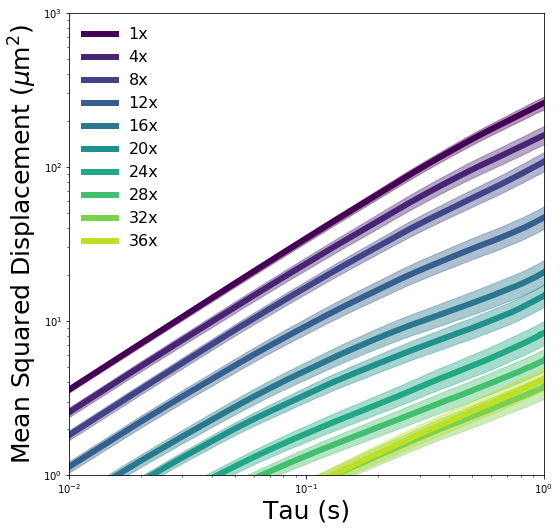

In [9]:
msd.plot_all_experiments(names,
                         yrange=(10**-0, 10**3), bucket=bucket, folder=folder,
                         labels = ['1x', '4x', '8x', '12x', '16x', '20x', '24x', '28x', '32x', '36x'])

In [2]:
names = []
for i, j in enumerate(['1x', '4x', '8x', '12x', '16x', '20x', '24x', '28x', '32x', '36x']):
    sample_name = 'stuck_spacing_{}'.format(i+1)
    names.append(sample_name)
    print(sample_name)

stuck_spacing_1
stuck_spacing_2
stuck_spacing_3
stuck_spacing_4
stuck_spacing_5
stuck_spacing_6
stuck_spacing_7
stuck_spacing_8
stuck_spacing_9
stuck_spacing_10


In [3]:
import numpy.ma as ma
geo = {}
gstder = {}
counter = 0
for counter, experiment in enumerate(names):

    geo[counter] = np.genfromtxt('geomean_{}.csv'.format(experiment))
    gstder[counter] = np.genfromtxt('geoSEM_{}.csv'.format(experiment))
    geo[counter] = ma.masked_equal(geo[counter], 0.0)
    gstder[counter] = ma.masked_equal(gstder[counter], 0.0)
    if counter == 0:
        normalize = np.exp(geo[counter][100])
    
    print('Experiment {0}: {1:0.2f}'.format(experiment, normalize/np.exp(geo[counter][100]) - 1))

Experiment stuck_spacing_1: 0.00
Experiment stuck_spacing_2: 0.09
Experiment stuck_spacing_3: 0.20
Experiment stuck_spacing_4: 0.32
Experiment stuck_spacing_5: 0.71
Experiment stuck_spacing_6: 1.15
Experiment stuck_spacing_7: 2.01
Experiment stuck_spacing_8: 3.45
Experiment stuck_spacing_9: 5.81
Experiment stuck_spacing_10: 6.82


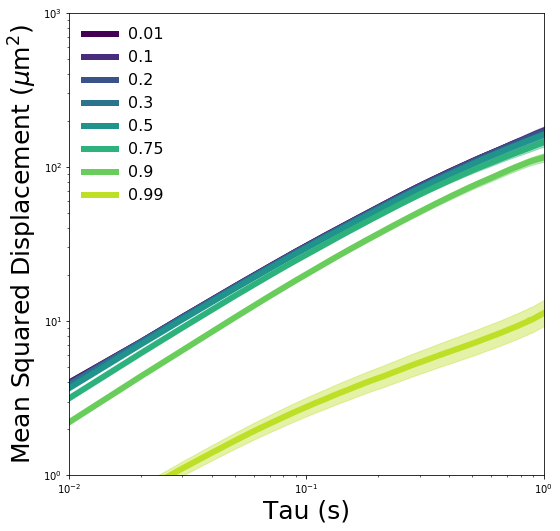

In [83]:
msd.plot_all_experiments(names,
                         yrange=(10**-0, 10**3), bucket=bucket, folder=folder,
                         labels = [0.01, 0.1, 0.2, 0.3, 0.5, 0.75, 0.9, 0.99])

(0, 512)

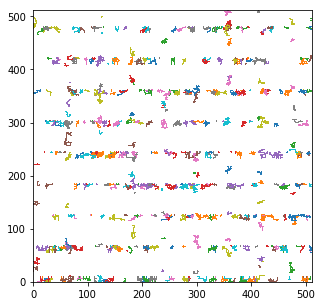

In [87]:
fig, ax = plt.subplots(figsize=(5,5))
for i in range(499):
    ax.plot(dataf[dataf['Track_ID']==i]['X'], dataf[dataf['Track_ID']==i]['Y'], linewidth=1)
ax.set_xlim([0, 512])
ax.set_ylim([0, 512])

In [ ]:
vals = np.array([1, 2, 3, 4])
np.argmin(vals)

In [ ]:
start = (256, 256)
while not zeros[start[0], start[1]]:
    start = (start[0], start[1]+1)
print(start)

xs, ys = random_walk(start=(256, 256), step=0.75, mask=zeros, stuckprob=0.1)
plt.plot(xs, ys, linewidth=5)
plt.xlim([0, 512])
plt.ylim([0, 512])

In [ ]:
xs

In [ ]:
ys

In [ ]:
x, y

In [ ]:
xs, ys = random_walk()
xs = xs*0.1 + np.random.randint(low=0, high=512-1)
ys = ys*0.1 + np.random.randint(low=0, high=512-1)

counter = True
for x, y in zip(xs.astype(int), ys.astype(int)):
    if not zeros[x, y]:
        counter = False
print(counter)

In [ ]:
ys